In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import xgboost


## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [3]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [5]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [6]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

## Практика

In [7]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [9]:
#Функция добавляет колонку day_of_transaction = 0,1,2,3,4,5,6, в зависимоти от дня недели транзакции
def add_day_col(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    return dataset

#Функция добавляет колонку daytime_of_transaction = night,morning,daytime,evening, в зависимоти от времени транзакции
def add_daytime_col(dataset):
    dataset['daytime_of_transaction'] = dataset['TRDATETIME'].apply(
            lambda x: (
                'night' if 0 <= int(datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S').strftime('%H')) < 6
                else 'morning' if 6 <= int(datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S').strftime('%H')) < 12
                else 'daytime' if 12 <= int(datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S').strftime('%H')) < 18
                else 'evening' if 18 <= int(datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S').strftime('%H')) < 24
                else 'unknown'
            )
    ) 
    return dataset

# transaction_by_day_count(raw_df)
# transaction_by_daytime_count(raw_df)

### Агрегирование с помощью Pandas

In [10]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [52]:
raw_df['MCC'].value_counts().head(55)

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
5541     19816
5912     18728
5999     13073
6012     10056
5921      8578
5331      7641
4121      6266
5211      6262
4829      6205
5691      5161
5261      4803
4111      4362
5977      4300
5200      3460
5732      3271
5311      3258
5533      2946
5651      2915
4812      2857
5641      2710
8099      2674
5722      2667
5661      2601
8999      2599
5941      2597
5945      2461
7011      2430
4814      2416
5712      2415
7832      1987
7230      1862
4112      1854
5813      1844
5964      1841
5699      1741
5992      1729
4511      1647
5995      1588
5983      1563
4900      1473
7997      1420
5942      1420
5621      1045
5399      1038
5735       990
7311       899
5300       899
4784       898
4816       859
5944       831
Name: MCC, dtype: int64

In [53]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

mccs = pd.DataFrame(raw_df['MCC'].value_counts())
mccs = mccs.head(55)
mccs = mccs.reset_index()
transactions_train['MCC'] = transactions_train['MCC'].apply(lambda x : x if x in list(mccs['index']) else -1)
transactions_test['MCC'] = transactions_test['MCC'].apply(lambda x : x if x in list(mccs['index']) else -1)
# Мы выбрали наиболее популярные MCC коды, остальные заменили на -1(прочее)

currencys = pd.DataFrame(transactions_train['currency'].value_counts())
currencys = currencys.head(5)
currencys = mccs.reset_index()
transactions_train['currency'] = transactions_train['currency'].apply(lambda x : x if x in list(currencys['index']) else -1)
transactions_test['currency'] = transactions_test['currency'].apply(lambda x : x if x in list(currencys['index']) else -1)
# Мы выбрали наиболее популярные валюты, остальные заменили на -1(прочее)

transactions_train = add_day_col(transactions_train)
transactions_test = add_day_col(transactions_test)
# Добавили колонку day_of_transaction = 0,1,2,3,4,5,6, в зависимоти от дня недели транзакции

transactions_train = add_daytime_col(transactions_train)
transactions_test = add_daytime_col(transactions_test)
# Добавили колонку daytime_of_transaction = night,morning,daytime,evening, в зависимоти от времени транзакции


Total transactions in train dataset:  391672
Total transactions in test dataset:  98841


In [54]:
transactions_train.shape

(391672, 12)

In [55]:
transactions_test.shape

(98841, 12)

In [56]:
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='MCC'),
    left_index = True,
    right_index = True
)
df_test_mcc = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='MCC'),
    left_index = True,
    right_index = True
)

In [57]:
df_train_mcc.shape

(4000, 112)

In [58]:
df_test_mcc.shape

(1000, 112)

In [59]:
df_train_trx_category = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    left_index = True,
    right_index = True
)

df_test_trx_category = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='trx_category'),
    left_index = True,
    right_index = True
)

In [60]:
df_train_currency = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='currency'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='currency'),
    left_index = True,
    right_index = True
)

df_test_currency = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='currency'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='currency'),
    left_index = True,
    right_index = True
)

In [61]:
df_train_mcctrx = pd.merge(
    df_train_mcc,
    df_train_trx_category,
    left_index = True,
    right_index = True
)

df_test_mcctrx = pd.merge(
    df_test_mcc,
    df_test_trx_category,
    left_index = True,
    right_index = True
)

In [62]:
df_train_mcctrx = pd.merge(
    df_train_mcctrx,
    df_train_currency,
    left_index = True,
    right_index = True
)

df_test_mcctrx = pd.merge(
    df_test_mcctrx,
    df_test_currency,
    left_index = True,
    right_index = True
)


In [63]:
df_train_mcctrx.shape

(4000, 134)

In [64]:
df_test_mcctrx.shape

(1000, 134)

In [65]:
df_train_dayday = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='day_of_transaction'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='day_of_transaction'),
    left_index = True,
    right_index = True
)
df_test_dayday = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='day_of_transaction'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='day_of_transaction'),
    left_index = True,
    right_index = True
)

In [66]:
df_train_daytime = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='daytime_of_transaction'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='daytime_of_transaction'),
    left_index = True,
    right_index = True
)
df_test_daytime = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='daytime_of_transaction'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='daytime_of_transaction'),
    left_index = True,
    right_index = True
)

In [67]:
df_train_daytime = pd.merge(
    df_train_dayday,
    df_train_daytime,
    left_index = True,
    right_index = True
)
df_test_daytime = pd.merge(
    df_test_dayday,
    df_test_daytime,
    left_index = True,
    right_index = True
)

In [68]:
df_train_daytime.shape

(4000, 22)

In [69]:
df_test_daytime.shape

(1000, 22)

In [70]:
df_train_mcctrx.shape

(4000, 134)

In [71]:
df_test_mcctrx.shape

(1000, 134)

In [72]:
df_train = pd.merge(
    df_train_mcctrx,
    df_train_daytime,
    left_index = True,
    right_index = True
)
df_test = pd.merge(
    df_test_mcctrx,
    df_test_daytime,
    left_index = True,
    right_index = True
)

In [73]:
df_train.shape

(4000, 156)

In [74]:
df_test.shape

(1000, 156)

In [75]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [76]:
df_train = pd.merge(
    df_train,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)
df_test = pd.merge(
    df_test,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [77]:
df_train.shape

(4000, 157)

In [78]:
df_test.shape

(1000, 157)

In [79]:
x_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']
x_test = df_test.drop(['target_flag'], axis=1)
y_test = df_test['target_flag']

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
clf = LogisticRegression()

In [82]:
clf.fit(X=x_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve

In [84]:
y_train_predict = clf.predict_proba(x_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.76


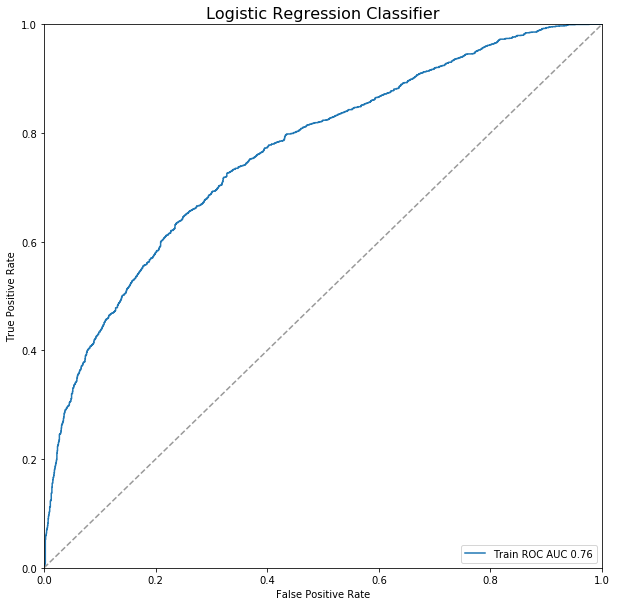

In [85]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [87]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.98
Test:  0.79


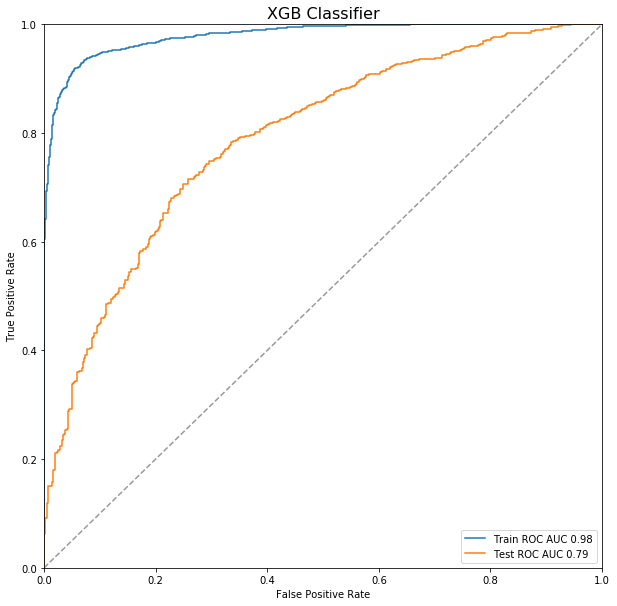

In [88]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()